In [1]:
import pandas as pd

df = pd.read_excel('../../data/Outscraper.xlsx')
print(df.head())

                                     query                         name  \
0  restaurant, 19148, Philadelphia, PA, US  Wokworks South Philadelphia   
1  restaurant, 19148, Philadelphia, PA, US                    Mish Mish   
2  restaurant, 19148, Philadelphia, PA, US                 Oregon Diner   
3  restaurant, 19148, Philadelphia, PA, US              1731 Restaurant   
4  restaurant, 19148, Philadelphia, PA, US            Popi's Restaurant   

               name_for_emails  \
0  Wokworks South Philadelphia   
1                    Mish Mish   
2                 Oregon Diner   
3              1731 Restaurant   
4             Popis Restaurant   

                                                site  \
0  https://wokworks.typeform.com/to/wZxsXfXS?type...   
1                    https://www.mishmishphilly.com/   
2                      http://oregondinerphilly.com/   
3                        https://1731restaurant.com/   
4                    http://www.popisrestaurant.com/   

       

In [2]:
subdf=pd.read_csv('../../data/census_subset_clean.csv')

In [3]:
df[['population', 'median_income']] = subdf[['population', 'median_income']]

In [4]:
def categorize(text):
    for category, keywords in keyword_map.items():
        if any(keyword.lower() in text.lower() for keyword in keywords):
            return category
    return "other"  
keyword_map = {
    "Asian food": [
        "Vietnamese", "Sichuan", "Japanese", "Indonesian", "Thai", "Chinese", 
        "Korean", "Filipino", "Malaysian", "Taiwanese", "Pakistani", "Afghan", 
        "Nepalese", "Tibetan", "Cambodian", "Asian", "Pan-Asian", "Southeast Asian",
        "Dan Dan", "Pho", "Shabu-shabu", "Ramen"
    ],
    "European and US food": [
        "Italian", "European", "American", "Western", "US", "French", "Irish", 
        "Greek", "Portuguese", "German", "Spanish", "Swedish", "Polish", 
        "British", "Dutch", "Modern European", "Mid-Atlantic", "Southern Italian"
    ],
    "African food": [
        "Ethiopian", "Eritrean", "Moroccan", "Tunisian", "West African", "African"
    ],
    "Middle Eastern food": [
        "Lebanese", "Israeli", "Turkish", "Halal", "Kosher", "Georgian", "Yemeni"
    ],
    "Latin American and Caribbean food": [
        "Mexican", "Honduran", "Salvadoran", "Guatemalan", "Colombian", 
        "Brazilian", "Argentinian", "Peruvian", "Puerto Rican", "Cuban", 
        "Venezuelan", "Latin American", "Caribbean"
    ],
    "Indian food": [
        "Indian", "Modern Indian", "South Indian", "Indian takeaway"
    ],
    "Fast food": [
        "Pizza", "Fast food", "Fried chicken", "Hot dog", "Burger", 
        "Takeout", "Delivery", "Wings", "Donut", "Burrito", "Taco"
    ],
    "Vegan and healthy food": [
        "Vegan", "Vegetarian", "Organic", "Health food", "Salad", "Raw food", 
        "Juice", "Açaí", "Fresh food"
    ],
    "Desserts and snacks": [
        "Ice cream", "Dessert", "Snack", "Pretzel", "Bakery", "Creperie", "Donut"
    ],
    "Drinks and bars": [
        "Bar", "Cocktail", "Pub", "Brewery", "Beer", "Wine", "Liquor", 
        "Beer garden", "Brewpub", "Karaoke", "Hookah", "Lounge", "Club", 
        "Sports bar", "Coffee", "Tea", "Juice"
    ],
    "Seafood": [
        "Seafood", "Crab", "Oyster", "Fish & chips"
    ],
    "Buffet and mixed cuisine": [
        "Buffet", "Fusion", "Eclectic", "Dim sum", "Asian fusion"
    ],
    "Specialty or ethnic": [
        "Cambodian", "Uzbeki", "Ecuadorian", "Georgian", "Jewish", "Bangladeshi", "Laotian"
    ],
    "Catering and service": [
        "Caterer", "Catering", "Personal chef", "Mobile caterer", "Cooking class", 
        "Event", "Entertainment", "Catering equipment"
    ],
    "Other / uncategorized": [
        "Market", "Grocery", "Store", "Mall", "Hotel", "Bed & breakfast", 
        "Convenience store", "Food court", "Shopping", "Self service", 
        "Association", "Vitamin", "Smoke shop", "Lingerie"
    ]
}
df["category"] = df["type"].astype(str).apply(categorize)

In [5]:
df.groupby('type').rating.mean()
price_mapping = {'$': 1, '$$': 2, '$$$': 3, '$$$$': 4}
df['price'] = df['range'].map(price_mapping) 


In [6]:
df = df.dropna(subset=["rating"])
df["rating"] = df["rating"].fillna(df["rating"].median()) 
df = df.dropna(subset=["rating"])
df['price'].fillna(df['price'].median(), inplace=True)
df = df[df['city'].str.contains('Philadelphia', case=False, na=False)]

In [10]:
from matplotlib import pyplot as plt
import seaborn as sns

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

In [13]:
n_splits=5
kfold = KFold(n_splits=5)
df_train, df_test = train_test_split(df,test_size=.2,random_state=42,stratify=df.category)

In [14]:
ks = range(1,40)
mse=np.zeros(len(ks))
k_mse = np.zeros((n_splits,len(ks)))
all_features=['latitude', 'longitude']
i = 0
for train_index, test_index in kfold.split(df_train,df_train.rating):
    df_tt = df_train.iloc[train_index]
    df_ho = df_train.iloc[test_index]
    j = 0
    for k in ks:
        ## Make the model object
        knn = Pipeline([('scale',StandardScaler()),('knn',KNeighborsRegressor(k))])
        
        ## Fit the model
        knn.fit(df_tt[all_features].values,df_tt.rating.values)
        ## Make your prediction
        pred = knn.predict(df_ho[all_features].values)
        k_mse[i,j] = mean_squared_error(df_ho.rating.values, pred)
        
        j = j + 1
    i = i + 1
mse=np.mean(k_mse,axis=0)

In [15]:
k_0=np.argmin(mse)
print(k_0+1,mse[k_0])

21 0.2827134744531902


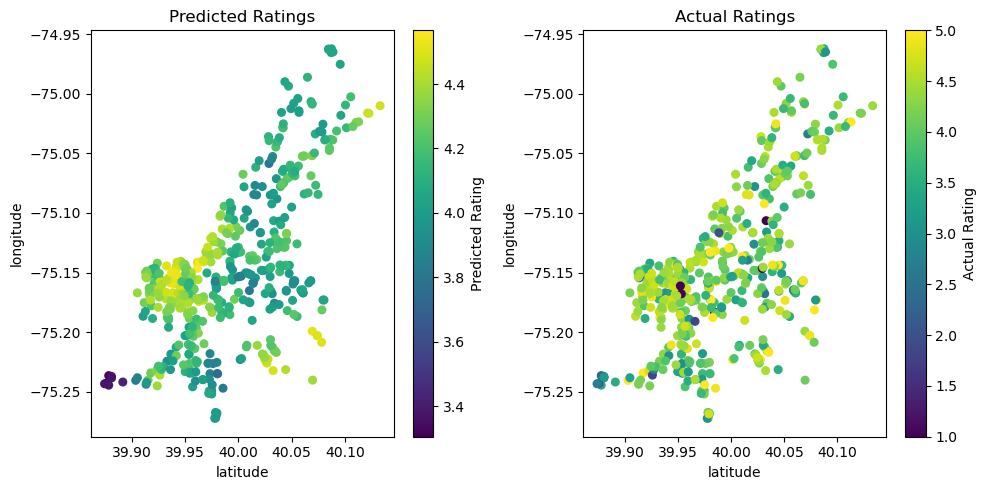

In [29]:
x_pos = df_ho['latitude'].values
y_pos = df_ho['longitude'].values
mse=0
all_pred = []
all_true = []
all_x = []
all_y = []
df_tt,df_ho=train_test_split(df_train,test_size=.2,stratify=df_train.category)
knn = Pipeline([
        ('scale', StandardScaler()),
        ('knn', KNeighborsRegressor(n_neighbors=k_0+1))
    ])
    
knn.fit(df_tt[all_features].values, df_tt.rating.values)
pred = knn.predict(df_ho[all_features].values)
mse=mean_squared_error(df_ho.rating.values,pred)    
all_pred.extend(pred)
all_true.extend(df_ho.rating.values)
all_x.extend(df_ho['latitude'].values)
all_y.extend(df_ho['longitude'].values)

# === Plot 1: Predicted Ratings ===
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
scatter1 = plt.scatter(all_x, all_y, c=all_pred, cmap='viridis', s=30)
plt.colorbar(scatter1, label='Predicted Rating')
plt.title('Predicted Ratings')
plt.xlabel('latitude')
plt.ylabel('longitude')

# === Plot 2: Actual Ratings ===
plt.subplot(1, 2, 2)
scatter2 = plt.scatter(all_x, all_y, c=all_true, cmap='viridis', s=30)
plt.colorbar(scatter2, label='Actual Rating')
plt.title('Actual Ratings')
plt.xlabel('latitude')
plt.ylabel('longitude')

plt.tight_layout()
plt.show()

In [30]:
mse

0.3370209701099754

In [31]:
residual = np.array(all_true) - np.array(all_pred)

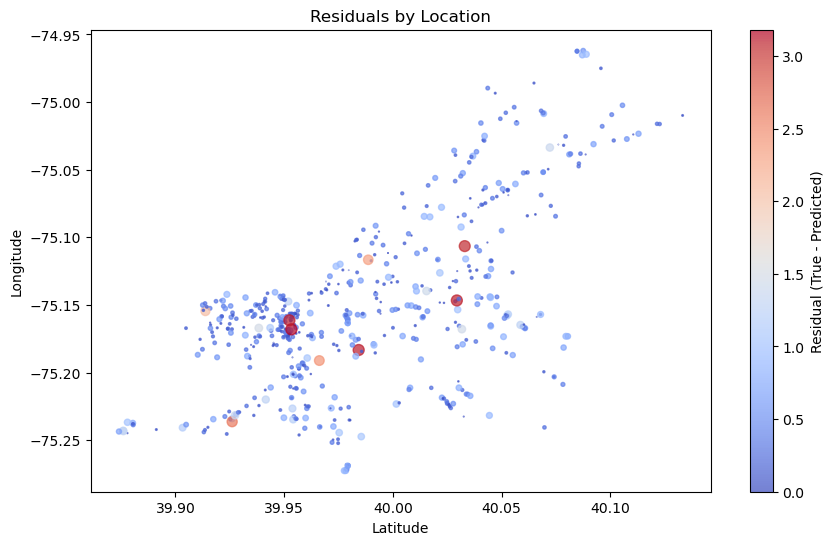

In [32]:
abs_residual = np.abs(residual)
plt.figure(figsize=(10, 6))
sc = plt.scatter(all_x, all_y, c=abs_residual, cmap='coolwarm', s=abs_residual * 20, alpha=0.7)
plt.colorbar(sc, label="Residual (True - Predicted)")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Residuals by Location")
plt.show()

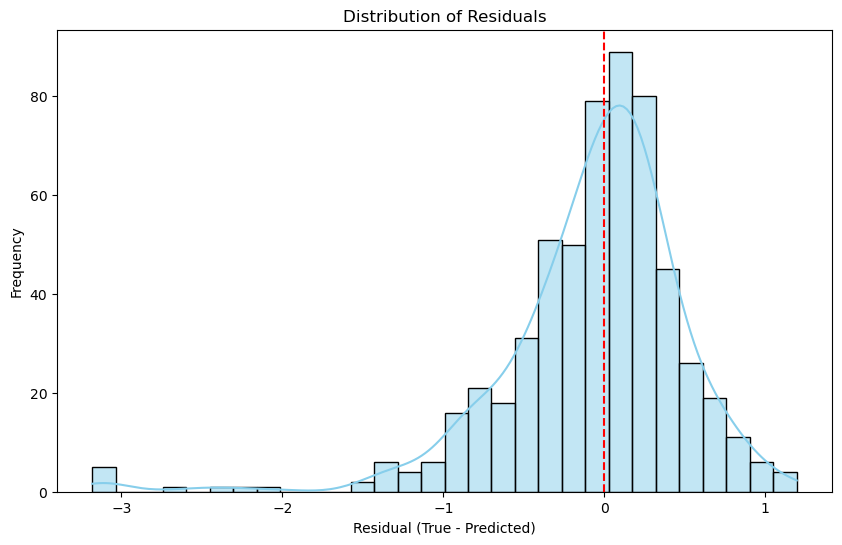

In [33]:
plt.figure(figsize=(10, 6))
sns.histplot(residual, kde=True, bins=30, color='skyblue')
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribution of Residuals")
plt.xlabel("Residual (True - Predicted)")
plt.ylabel("Frequency")
plt.show()

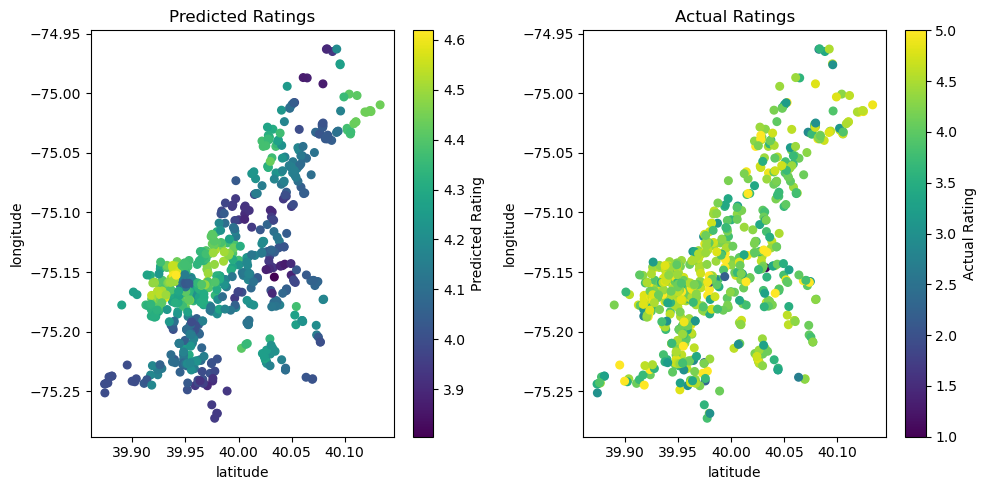

In [34]:
x_pos = df_test['latitude'].values
y_pos = df_test['longitude'].values
mse=0
all_pred = []
all_true = []
all_features=['latitude', 'longitude']
all_x = []
all_y = []
knn = Pipeline([
        ('scale', StandardScaler()),
        ('knn', KNeighborsRegressor(n_neighbors=k_0+1))
    ])
    
knn.fit(df_test[all_features].values, df_test.rating.values)
pred = knn.predict(df_test[all_features].values)
mse=mean_squared_error(df_test.rating.values,pred)    
all_pred.extend(pred)
all_true.extend(df_test.rating.values)
all_x.extend(df_test['latitude'].values)
all_y.extend(df_test['longitude'].values)

# === Plot 1: Predicted Ratings ===
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
scatter1 = plt.scatter(all_x, all_y, c=all_pred, cmap='viridis', s=30)
plt.colorbar(scatter1, label='Predicted Rating')
plt.title('Predicted Ratings')
plt.xlabel('latitude')
plt.ylabel('longitude')

# === Plot 2: Actual Ratings ===
plt.subplot(1, 2, 2)
scatter2 = plt.scatter(all_x, all_y, c=all_true, cmap='viridis', s=30)
plt.colorbar(scatter2, label='Actual Rating')
plt.title('Actual Ratings')
plt.xlabel('latitude')
plt.ylabel('longitude')

plt.tight_layout()
plt.show()

In [35]:
mse

0.24825915489394268

In [36]:
residual = np.array(all_true) - np.array(all_pred)

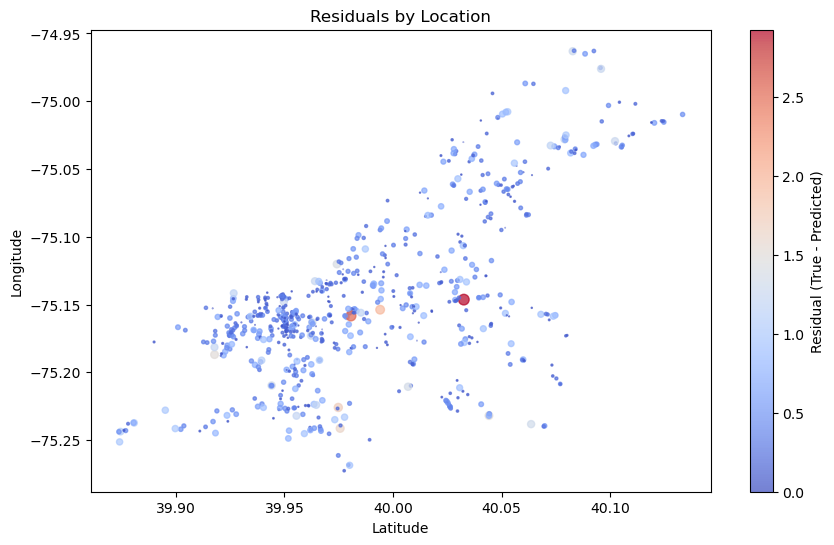

In [37]:
abs_residual = np.abs(residual)
plt.figure(figsize=(10, 6))
sc = plt.scatter(all_x, all_y, c=abs_residual, cmap='coolwarm', s=abs_residual * 20, alpha=0.7)
plt.colorbar(sc, label="Residual (True - Predicted)")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Residuals by Location")
plt.show()

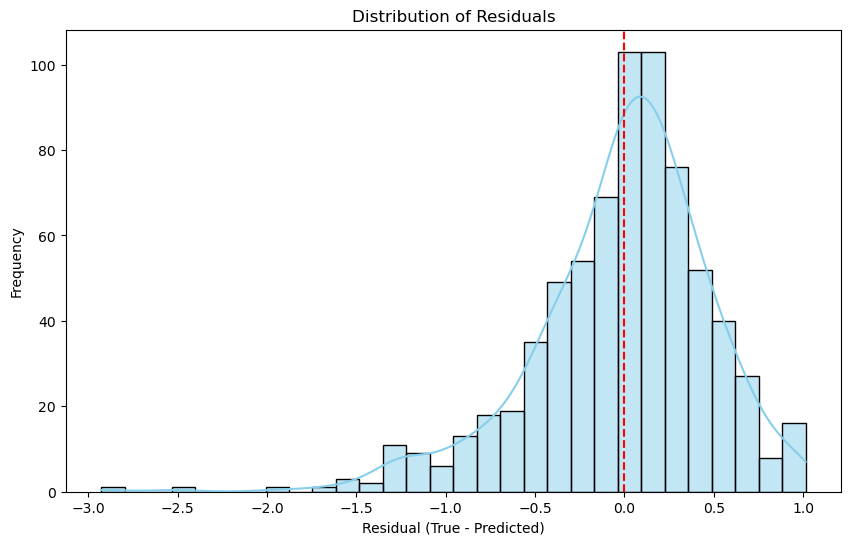

In [38]:
plt.figure(figsize=(10, 6))
sns.histplot(residual, kde=True, bins=30, color='skyblue')
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribution of Residuals")
plt.xlabel("Residual (True - Predicted)")
plt.ylabel("Frequency")
plt.show()